<a href="https://www.kaggle.com/code/mesutssmn/titanic-spaceship-ml-ann?scriptVersionId=165773323" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,mean_squared_error,accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
df = pd.concat([train, test], ignore_index=True).reset_index(drop=True)
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000,False,0.000,0.000,0.000,0.000,0.000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000,False,109.000,9.000,25.000,549.000,44.000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000,True,43.000,3576.000,0.000,6715.000,49.000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000,False,0.000,1283.000,371.000,3329.000,193.000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000,False,303.000,70.000,151.000,565.000,2.000,Willy Santantines,True


# *File and Data Field Descriptions*


*   **train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
*   **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
*   **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
*   **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
*   **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
*   **Destination** - The planet the passenger will be debarking to.
*   **Age** - The age of the passenger.
*   **VIP** - Whether the passenger has paid for special VIP service during the voyage.
*   **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
*   **Name** - The first and last names of the passenger.
*   **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.





# *Data Informations & Manipulations*

In [4]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000,False,0.000,0.000,0.000,0.000,0.000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000,False,109.000,9.000,25.000,549.000,44.000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000,True,43.000,3576.000,0.000,6715.000,49.000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000,False,0.000,1283.000,371.000,3329.000,193.000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000,False,303.000,70.000,151.000,565.000,2.000,Willy Santantines,True


In [5]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000,12707.000,12681.000,12664.000,12686.000,12702.000
mean,28.772,222.898,451.962,174.906,308.477,306.789
std,14.387,647.597,1584.371,590.559,1130.280,1180.097
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,19.000,0.000,0.000,0.000,0.000,0.000
50%,27.000,0.000,0.000,0.000,0.000,0.000
75%,38.000,49.000,77.000,29.000,57.000,42.000
max,79.000,14327.000,29813.000,23492.000,22408.000,24133.000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


In [7]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    numeric_columns = dataframe.select_dtypes(include=['number']).columns
    print(dataframe[numeric_columns].quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [8]:
check_df(df)

##################### Shape #####################
(12970, 14)
##################### Types #####################
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported      object
dtype: object
##################### Head #####################
  PassengerId HomePlanet CryoSleep  Cabin  Destination    Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e 39.000  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e 24.000  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e 58.000   True   

   RoomService  FoodCourt  ShoppingMall      Spa  VRDeck             Name  \
0        0.000      0.000         0.000    0.000   0.000  Maham Ofracculy   
1      109.000      9.000        25.000  549.0

In [9]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

In [10]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 12970
Variables: 14
cat_cols: 5
num_cols: 6
cat_but_car: 3
num_but_cat: 0


In [11]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(8, 6))
        plt.subplot(1, 2, 1)
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.title("Frequency of " + col_name)
        plt.xticks(rotation=90)

        plt.subplot(1, 2, 2)
        values = dataframe[col_name].value_counts()
        plt.pie(x=values, labels=values.index, autopct=lambda p: '{:.2f}% ({:.0f})'.format(p, p/100 * sum(values)))
        plt.title("Frequency of " + col_name)
        plt.legend(labels=['{} - {:.2f}%'.format(index, value/sum(values)*100) for index, value in zip(values.index, values)],
                   loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=1)
        plt.show(block=True)

            HomePlanet  Ratio
HomePlanet                   
Earth             6865 52.930
Europa            3133 24.156
Mars              2684 20.694


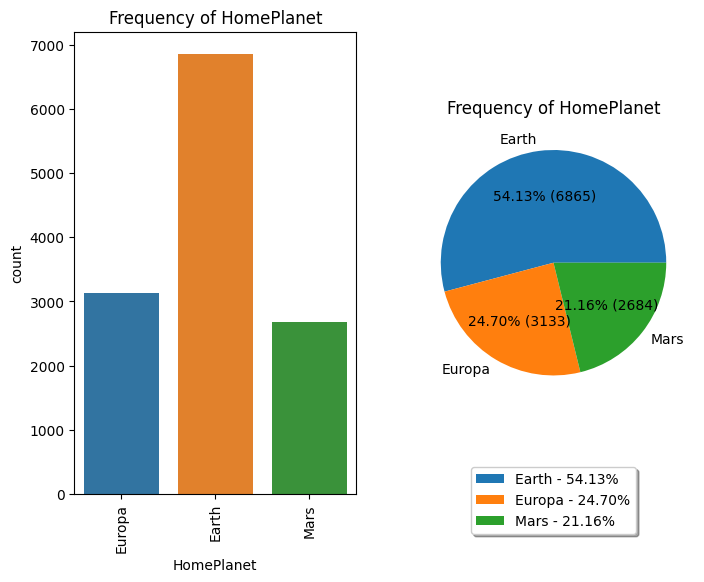

           CryoSleep  Ratio
CryoSleep                  
False           8079 62.290
True            4581 35.320


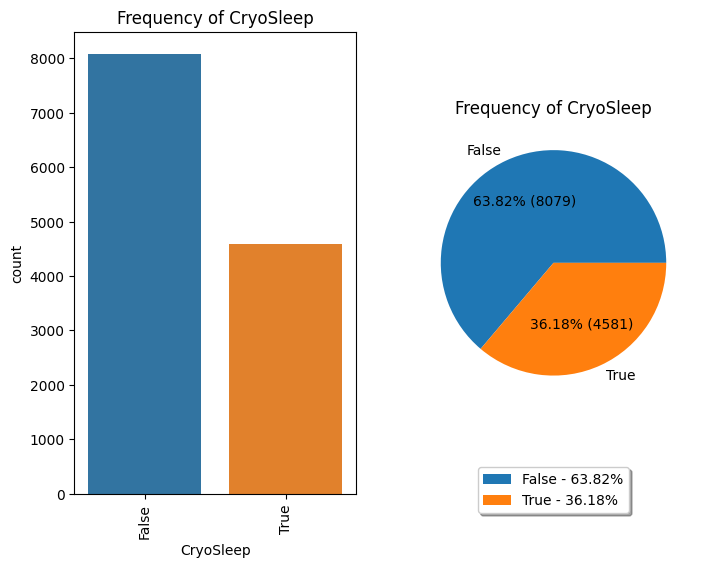

               Destination  Ratio
Destination                      
TRAPPIST-1e           8871 68.396
55 Cancri e           2641 20.362
PSO J318.5-22         1184  9.129


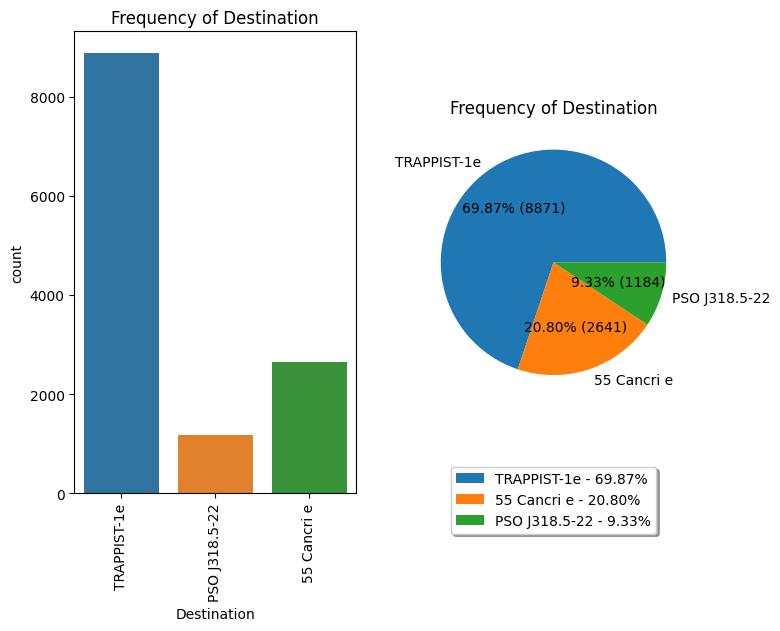

         VIP  Ratio
VIP                
False  12401 95.613
True     273  2.105


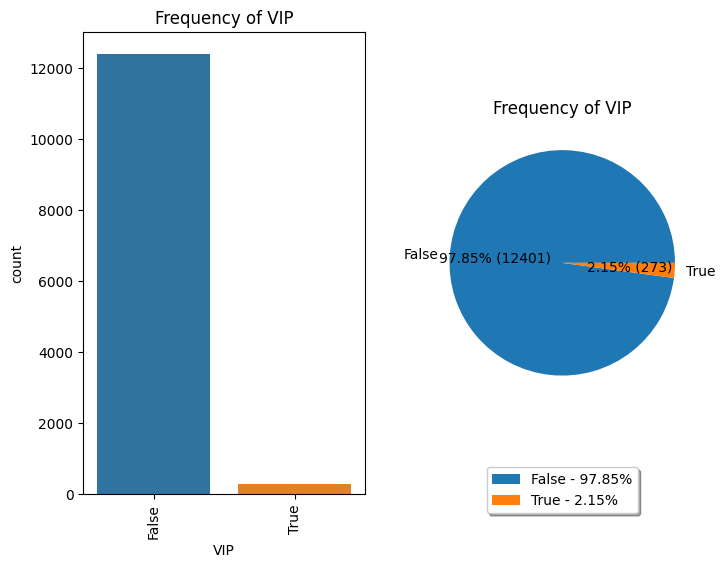

             Transported  Ratio
Transported                    
True                4378 33.755
False               4315 33.269


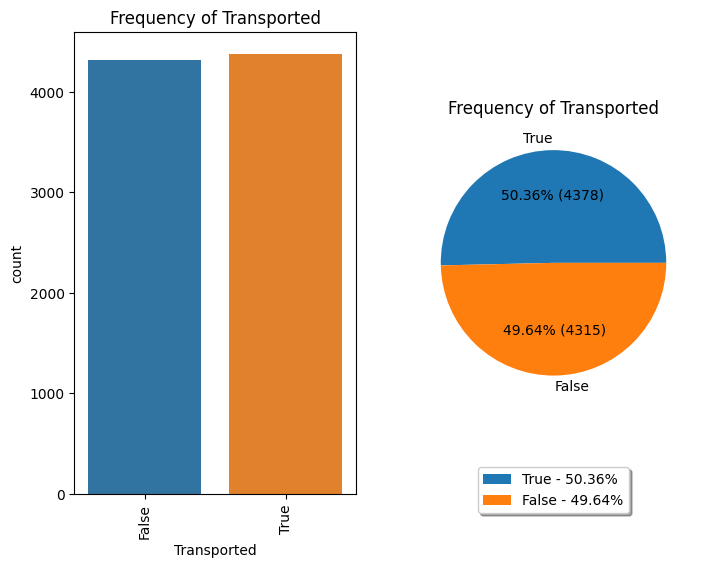

In [12]:
for col in cat_cols:
    cat_summary(df, col, True)

In [13]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")

count   12700.000
mean       28.772
std        14.387
min         0.000
5%          4.000
10%        13.000
20%        18.000
30%        21.000
40%        24.000
50%        27.000
60%        30.000
70%        35.000
80%        41.000
90%        49.000
95%        56.000
99%        65.010
max        79.000
Name: Age, dtype: float64


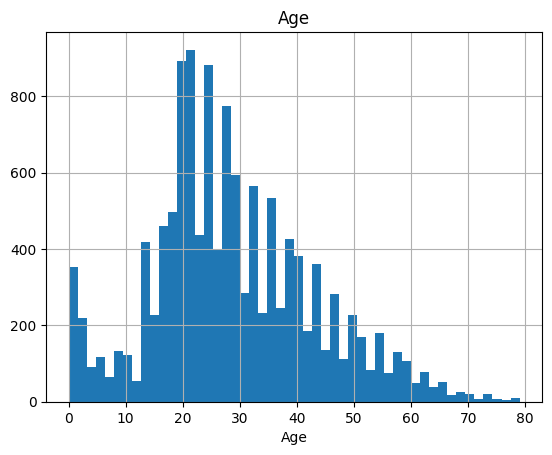

#####################################
count   12707.000
mean      222.898
std       647.597
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         8.000
80%       178.000
90%       765.400
95%      1275.800
99%      3009.520
max     14327.000
Name: RoomService, dtype: float64


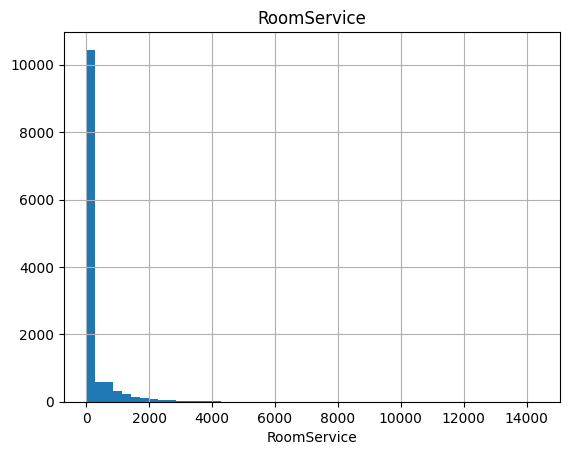

#####################################
count   12681.000
mean      451.962
std      1584.371
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%        12.000
80%       264.000
90%      1013.000
95%      2670.000
99%      7797.600
max     29813.000
Name: FoodCourt, dtype: float64


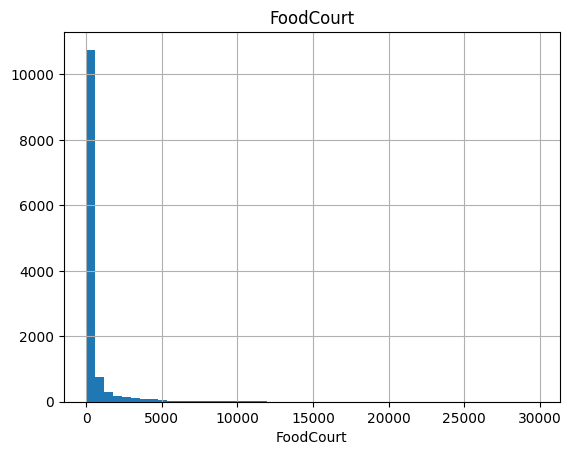

#####################################
count   12664.000
mean      174.906
std       590.559
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         5.000
80%        99.000
90%       622.000
95%       964.250
99%      2396.740
max     23492.000
Name: ShoppingMall, dtype: float64


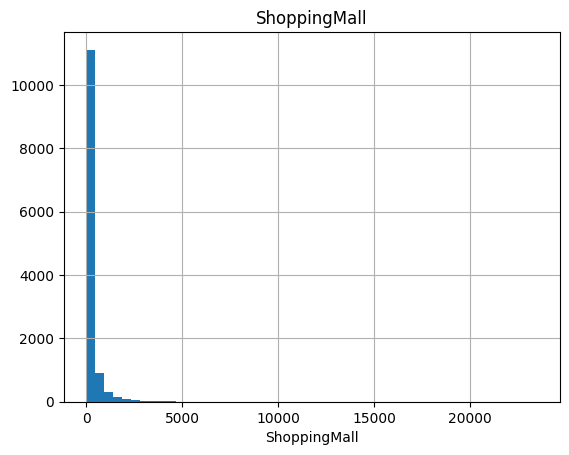

#####################################
count   12686.000
mean      308.477
std      1130.280
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%        14.000
80%       177.000
90%       733.500
95%      1589.000
99%      5435.900
max     22408.000
Name: Spa, dtype: float64


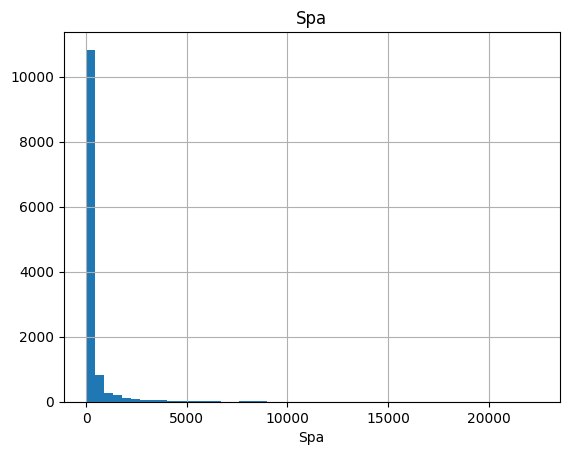

#####################################
count   12702.000
mean      306.789
std      1180.097
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         7.000
80%       141.000
90%       721.900
95%      1538.800
99%      5838.930
max     24133.000
Name: VRDeck, dtype: float64


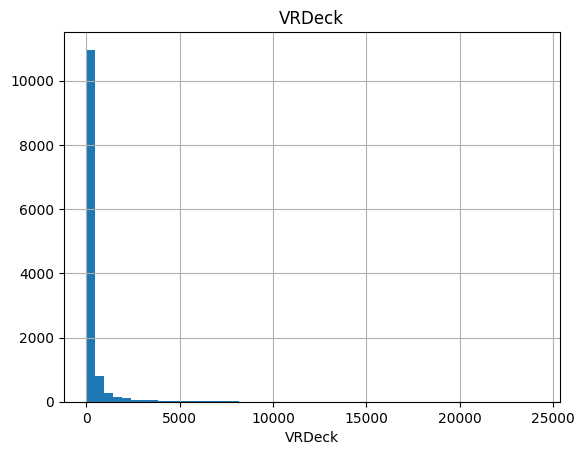

#####################################


In [14]:
for col in num_cols:
    num_summary(df, col, True)

In [15]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [16]:
for col in cat_cols:
    target_summary_with_cat(df,"Transported",col)

           TARGET_MEAN
HomePlanet            
Earth            0.424
Europa           0.659
Mars             0.523


          TARGET_MEAN
CryoSleep            
False           0.329
True            0.818


              TARGET_MEAN
Destination              
55 Cancri e         0.610
PSO J318.5-22       0.504
TRAPPIST-1e         0.471


      TARGET_MEAN
VIP              
False       0.506
True        0.382


            TARGET_MEAN
Transported            
False             0.000
True              1.000




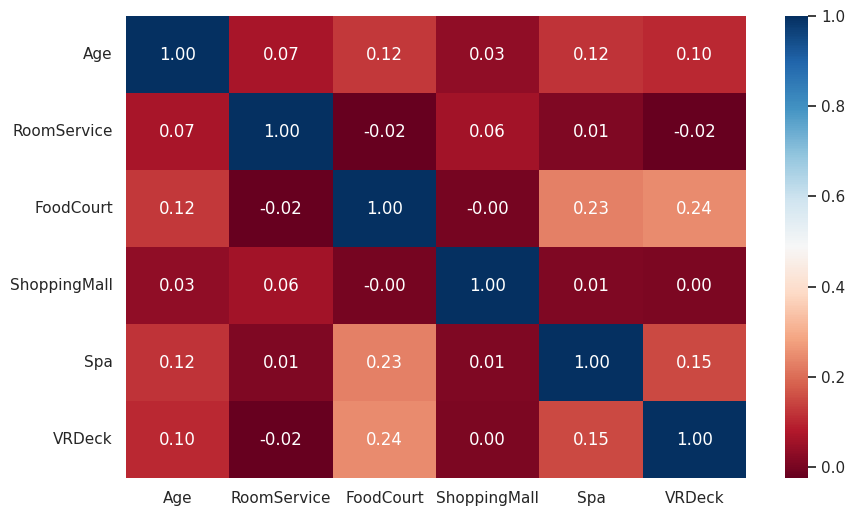

In [17]:
corr = df[num_cols].corr()
corr
sns.set(rc={'figure.figsize': (10, 6)})
sns.heatmap(corr, cmap="RdBu", annot=True, fmt=".2f")
plt.show()

In [18]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

In [19]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [20]:
for col in num_cols:
    if col != "Transported":
      print(col, check_outlier(df, col))

Age False
RoomService True
FoodCourt True
ShoppingMall True
Spa True
VRDeck True


In [21]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [22]:
for col in num_cols:
    if col != "Transported":
        replace_with_thresholds(df,col)

In [23]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [24]:
missing_values_table(df)


              n_miss  ratio
Transported     4277 32.980
CryoSleep        310  2.390
ShoppingMall     306  2.360
Cabin            299  2.310
VIP              296  2.280
Name             294  2.270
FoodCourt        289  2.230
HomePlanet       288  2.220
Spa              284  2.190
Destination      274  2.110
Age              270  2.080
VRDeck           268  2.070
RoomService      263  2.030


In [25]:
df[(df['CryoSleep'] == True) & ((df['RoomService'] > 0) | (df['FoodCourt'] > 0) | (df['ShoppingMall'] > 0) | (df['Spa'] > 0) | (df['VRDeck'] > 0))]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported


In [26]:
df.loc[(df['CryoSleep'] == True) & ((df['RoomService'] > 0) | (df['FoodCourt'] > 0) | (df['ShoppingMall'] > 0) | (df['Spa'] > 0) | (df['VRDeck'] > 0)),['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = 0

In [27]:
missing_values_table(df)

              n_miss  ratio
Transported     4277 32.980
CryoSleep        310  2.390
ShoppingMall     306  2.360
Cabin            299  2.310
VIP              296  2.280
Name             294  2.270
FoodCourt        289  2.230
HomePlanet       288  2.220
Spa              284  2.190
Destination      274  2.110
Age              270  2.080
VRDeck           268  2.070
RoomService      263  2.030


In [28]:
def quick_missing_imp(data, num_method="median", cat_length=20, target="Transported"):
    variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]
    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data

In [29]:
df = quick_missing_imp(df, num_method="median", cat_length=16)

# BEFORE
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

HomePlanet         0
CryoSleep          0
Cabin            299
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             294
Transported     4277
dtype: int64 




In [30]:
df["Cabin"]=df["Cabin"].fillna(df["Cabin"].mode)
df["Cabin"].isna().sum()

0

In [31]:
df.drop(['Name'],axis=1,inplace=True)

In [32]:
df.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported     4277
dtype: int64

In [33]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "Transported", cat_cols)

HomePlanet : 3
            COUNT  RATIO TARGET_MEAN
HomePlanet                          
Earth        7153  0.552       0.428
Europa       3133  0.242       0.659
Mars         2684  0.207       0.523


CryoSleep : 2
           COUNT  RATIO TARGET_MEAN
CryoSleep                          
False       8389  0.647       0.335
True        4581  0.353       0.818


Destination : 3
               COUNT  RATIO TARGET_MEAN
Destination                            
55 Cancri e     2641  0.204       0.610
PSO J318.5-22   1184  0.091       0.504
TRAPPIST-1e     9145  0.705       0.472


VIP : 2
       COUNT  RATIO TARGET_MEAN
VIP                            
False  12697  0.979       0.506
True     273  0.021       0.382


Transported : 2
             COUNT  RATIO TARGET_MEAN
Transported                          
False         4315  0.333       0.000
True          4378  0.338       1.000




In [34]:
df.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported     4277
dtype: int64

In [35]:
def Cabines(df): 
    deck = []
    num = []
    side = []
    for cabin in df['Cabin']:
        if isinstance(cabin, str):
            deck.append(cabin.split('/')[0])
            num.append(int(cabin.split('/')[1]))
            side.append(cabin.split('/')[-1])
        else:
            deck.append(None)
            num.append(None)
            side.append(None)
    return deck, num, side

deck, num, side = Cabines(df)

In [36]:
cabin = pd.DataFrame({'Deck':deck,'Num':num,'Side':side})
cabin

,Deck,Num,Side
0,B,0.000,P
1,F,0.000,S
2,A,0.000,S
3,A,0.000,S
4,F,1.000,S
...,...,...,...
12965,G,1496.000,S
12966,None,NaN,None
12967,D,296.000,P
12968,D,297.000,P


In [37]:
cabin.isna().sum()

Deck    299
Num     299
Side    299
dtype: int64

In [38]:
cabin["Deck"].fillna(cabin["Deck"].mode()[0], inplace=True)
cabin["Side"].fillna(cabin["Side"].mode()[0], inplace=True)
cabin["Num"].fillna(cabin["Num"].median(), inplace=True)
cabin["Num"] = cabin["Num"].astype("int")

In [39]:
cabin.isna().sum()

Deck    0
Num     0
Side    0
dtype: int64

In [40]:
df.drop('Cabin',axis=1,inplace=True)
df = pd.concat([df,cabin],axis=1)
df.tail()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side
12965,9266_02,Earth,True,TRAPPIST-1e,34.000,False,0.000,0.000,0.000,0.000,0.000,NaN,G,1496,S
12966,9269_01,Earth,False,TRAPPIST-1e,42.000,False,0.000,847.000,17.000,10.000,144.000,NaN,F,431,S
12967,9271_01,Mars,True,55 Cancri e,27.000,False,0.000,0.000,0.000,0.000,0.000,NaN,D,296,P
12968,9273_01,Europa,False,TRAPPIST-1e,27.000,False,0.000,2532.500,0.000,0.000,523.000,NaN,D,297,P
12969,9277_01,Earth,True,PSO J318.5-22,43.000,False,0.000,0.000,0.000,0.000,0.000,NaN,G,1498,S


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12970 non-null  object 
 2   CryoSleep     12970 non-null  bool   
 3   Destination   12970 non-null  object 
 4   Age           12970 non-null  float64
 5   VIP           12970 non-null  bool   
 6   RoomService   12970 non-null  float64
 7   FoodCourt     12970 non-null  float64
 8   ShoppingMall  12970 non-null  float64
 9   Spa           12970 non-null  float64
 10  VRDeck        12970 non-null  float64
 11  Transported   8693 non-null   object 
 12  Deck          12970 non-null  object 
 13  Num           12970 non-null  int64  
 14  Side          12970 non-null  object 
dtypes: bool(2), float64(6), int64(1), object(6)
memory usage: 1.3+ MB


In [42]:
df['total_spent']= df['RoomService']+ df['FoodCourt']+ df['ShoppingMall']+ df['Spa']+ df['VRDeck']

In [43]:
df['AgeGroup'] = 0
for i in range(6):
    df.loc[(df["Age"] >= 10*i) & (df["Age"] < 10*(i + 1)), 'AgeGroup'] = i

In [44]:
target_column = df['Transported']
df.drop("Transported", axis=1, inplace=True)

In [45]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

Observations: 12970
Variables: 16
cat_cols: 7
num_cols: 8
cat_but_car: 1
num_but_cat: 3


In [46]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side,total_spent,AgeGroup
0,0001_01,Europa,False,TRAPPIST-1e,39.000,False,0.000,0.000,0.000,0.000,0.000,B,0,P,0.000,3
1,0002_01,Earth,False,TRAPPIST-1e,24.000,False,109.000,9.000,25.000,549.000,44.000,F,0,S,736.000,2
2,0003_01,Europa,False,TRAPPIST-1e,58.000,True,43.000,2532.500,0.000,1833.750,49.000,A,0,S,4458.250,5
3,0003_02,Europa,False,TRAPPIST-1e,33.000,False,0.000,1283.000,371.000,1833.750,193.000,A,0,S,3680.750,3
4,0004_01,Earth,False,TRAPPIST-1e,16.000,False,303.000,70.000,151.000,565.000,2.000,F,1,S,1091.000,1


In [47]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
dfd = one_hot_encoder(df, cat_cols, drop_first=True)

In [48]:
binary_cols = [col for col in dfd.columns if dfd[col].dtypes == "O" and len(dfd[col].unique()) == 2]

for col in binary_cols:
    label_encoder(dfd, col)

In [49]:
binary_cols

[]

In [50]:
dfd = pd.concat([dfd, target_column], axis=1)

In [51]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                12970 non-null  object 
 1   Age                        12970 non-null  float64
 2   RoomService                12970 non-null  float64
 3   FoodCourt                  12970 non-null  float64
 4   ShoppingMall               12970 non-null  float64
 5   Spa                        12970 non-null  float64
 6   VRDeck                     12970 non-null  float64
 7   Num                        12970 non-null  int64  
 8   total_spent                12970 non-null  float64
 9   HomePlanet_Europa          12970 non-null  bool   
 10  HomePlanet_Mars            12970 non-null  bool   
 11  Destination_PSO J318.5-22  12970 non-null  bool   
 12  Destination_TRAPPIST-1e    12970 non-null  bool   
 13  Deck_B                     12970 non-null  boo

In [52]:
dfd.head()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,total_spent,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S,CryoSleep_True,VIP_True,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,AgeGroup_5,Transported
0,0001_01,39.000,0.000,0.000,0.000,0.000,0.000,0,0.000,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,0002_01,24.000,109.000,9.000,25.000,549.000,44.000,0,736.000,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True
2,0003_01,58.000,43.000,2532.500,0.000,1833.750,49.000,0,4458.250,True,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False
3,0003_02,33.000,0.000,1283.000,371.000,1833.750,193.000,0,3680.750,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
4,0004_01,16.000,303.000,70.000,151.000,565.000,2.000,1,1091.000,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,True


In [53]:
for i in dfd.columns:
    if dfd[i].dtype == bool:  
        dfd[i] = dfd[i].astype(int) 

In [54]:
dfd.head()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,total_spent,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S,CryoSleep_True,VIP_True,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,AgeGroup_5,Transported
0,0001_01,39.000,0.000,0.000,0.000,0.000,0.000,0,0.000,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False
1,0002_01,24.000,109.000,9.000,25.000,549.000,44.000,0,736.000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,True
2,0003_01,58.000,43.000,2532.500,0.000,1833.750,49.000,0,4458.250,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,False
3,0003_02,33.000,0.000,1283.000,371.000,1833.750,193.000,0,3680.750,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,False
4,0004_01,16.000,303.000,70.000,151.000,565.000,2.000,1,1091.000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,True


In [55]:
dfd[dfd['Transported'].notnull()]

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,total_spent,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S,CryoSleep_True,VIP_True,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,AgeGroup_5,Transported
0,0001_01,39.000,0.000,0.000,0.000,0.000,0.000,0,0.000,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False
1,0002_01,24.000,109.000,9.000,25.000,549.000,44.000,0,736.000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,True
2,0003_01,58.000,43.000,2532.500,0.000,1833.750,49.000,0,4458.250,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,False
3,0003_02,33.000,0.000,1283.000,371.000,1833.750,193.000,0,3680.750,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,False
4,0004_01,16.000,303.000,70.000,151.000,565.000,2.000,1,1091.000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,41.000,0.000,2532.500,0.000,1643.000,74.000,98,4249.500,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,False
8689,9278_01,18.000,0.000,0.000,0.000,0.000,0.000,1499,0.000,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,False
8690,9279_01,26.000,0.000,0.000,1555.000,1.000,0.000,1500,1556.000,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,True
8691,9280_01,32.000,0.000,1049.000,0.000,353.000,1804.750,608,3206.750,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,False


In [56]:
dfd[dfd['Transported'].isnull()]

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,total_spent,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S,CryoSleep_True,VIP_True,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,AgeGroup_5,Transported
8693,0013_01,27.000,0.000,0.000,0.000,0.000,0.000,3,0.000,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,NaN
8694,0018_01,19.000,0.000,9.000,0.000,1833.750,0.000,4,1842.750,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,NaN
8695,0019_01,31.000,0.000,0.000,0.000,0.000,0.000,0,0.000,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,NaN
8696,0021_01,38.000,0.000,2532.500,0.000,181.000,585.000,1,3298.500,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,NaN
8697,0023_01,20.000,10.000,0.000,635.000,0.000,0.000,5,645.000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,34.000,0.000,0.000,0.000,0.000,0.000,1496,0.000,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,NaN
12966,9269_01,42.000,0.000,847.000,17.000,10.000,144.000,431,1018.000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,NaN
12967,9271_01,27.000,0.000,0.000,0.000,0.000,0.000,296,0.000,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,NaN
12968,9273_01,27.000,0.000,2532.500,0.000,0.000,523.000,297,3055.500,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,NaN


In [57]:
train = dfd[dfd['Transported'].notnull()]
test = dfd[dfd['Transported'].isnull()]

In [58]:
train['Transported'] = train['Transported'].astype(int)

In [59]:
train.head()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,total_spent,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S,CryoSleep_True,VIP_True,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,AgeGroup_5,Transported
0,0001_01,39.000,0.000,0.000,0.000,0.000,0.000,0,0.000,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0002_01,24.000,109.000,9.000,25.000,549.000,44.000,0,736.000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
2,0003_01,58.000,43.000,2532.500,0.000,1833.750,49.000,0,4458.250,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
3,0003_02,33.000,0.000,1283.000,371.000,1833.750,193.000,0,3680.750,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,0004_01,16.000,303.000,70.000,151.000,565.000,2.000,1,1091.000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1


In [60]:
y = train['Transported']
X = train.drop(["PassengerId", "Transported"], axis=1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [62]:
models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier(n_estimators=200)),
          ('SVC', SVC()),
          ('GBM', GradientBoostingClassifier(n_estimators=200, learning_rate=0.06)),
          ("XGBoost", XGBClassifier(learning_rate=0.06)),
          ("LightGBM", LGBMClassifier(learning_rate=0.06, verbose=0)),
          ("CatBoost", CatBoostClassifier(learning_rate=0.06,verbose=False))]

In [63]:
acclist=[]
for name, model in models:
    acc = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy"))
    acclist.append([name,acc])
    print(f"ACC: {round(acc, 4)} ({name}) ")

ACC: 0.7906 (LR) 
ACC: 0.7691 (KNN) 
ACC: 0.7508 (CART) 
ACC: 0.8036 (RF) 
ACC: 0.7879 (SVC) 
ACC: 0.8057 (GBM) 
ACC: 0.8049 (XGBoost) 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
ACC: 0.8087 (LightGBM) 
ACC: 0.8102 (CatBoost) 


In [64]:
train_df = dfd[dfd['Transported'].notnull()]

target_column = train_df['Transported']
if target_column.dtype.kind in 'biufc':
    y = np.log1p(target_column)

In [65]:
X = train_df.drop(["PassengerId","Transported"], axis=1)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [67]:
catboost = CatBoostClassifier(verbose=False, learning_rate=0.09).fit(X_train, y_train)
y_pred = catboost.predict(X_test)
catboost.score(X_train, y_train)

0.9636180615473109

In [68]:
y_pred = np.expm1(y_pred)
y_test = np.expm1(y_test)

In [69]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.7719659849827146

In [70]:
catboost_model = CatBoostClassifier(verbose=False, random_state=46)

rmse = np.mean(np.sqrt(-cross_val_score(catboost_model, X, y, cv=5, scoring="neg_mean_squared_error")))
rmse

0.4653448336017686

In [71]:
catboost_params = {"learning_rate": [0.01, 0.04, 0.06, 0.08, 0.1],
               "n_estimators": [200, 400, 500, 1000, 1500]}
catboost_gs_best = GridSearchCV(catboost_model,
                            catboost_params,
                            cv=3,
                            n_jobs=-1,
                            verbose=False).fit(X_train, y_train)

In [72]:
final_model = catboost_model.set_params(**catboost_gs_best.best_params_).fit(X, y)

In [73]:
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 30))
    sns.set(font_scale=0.5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

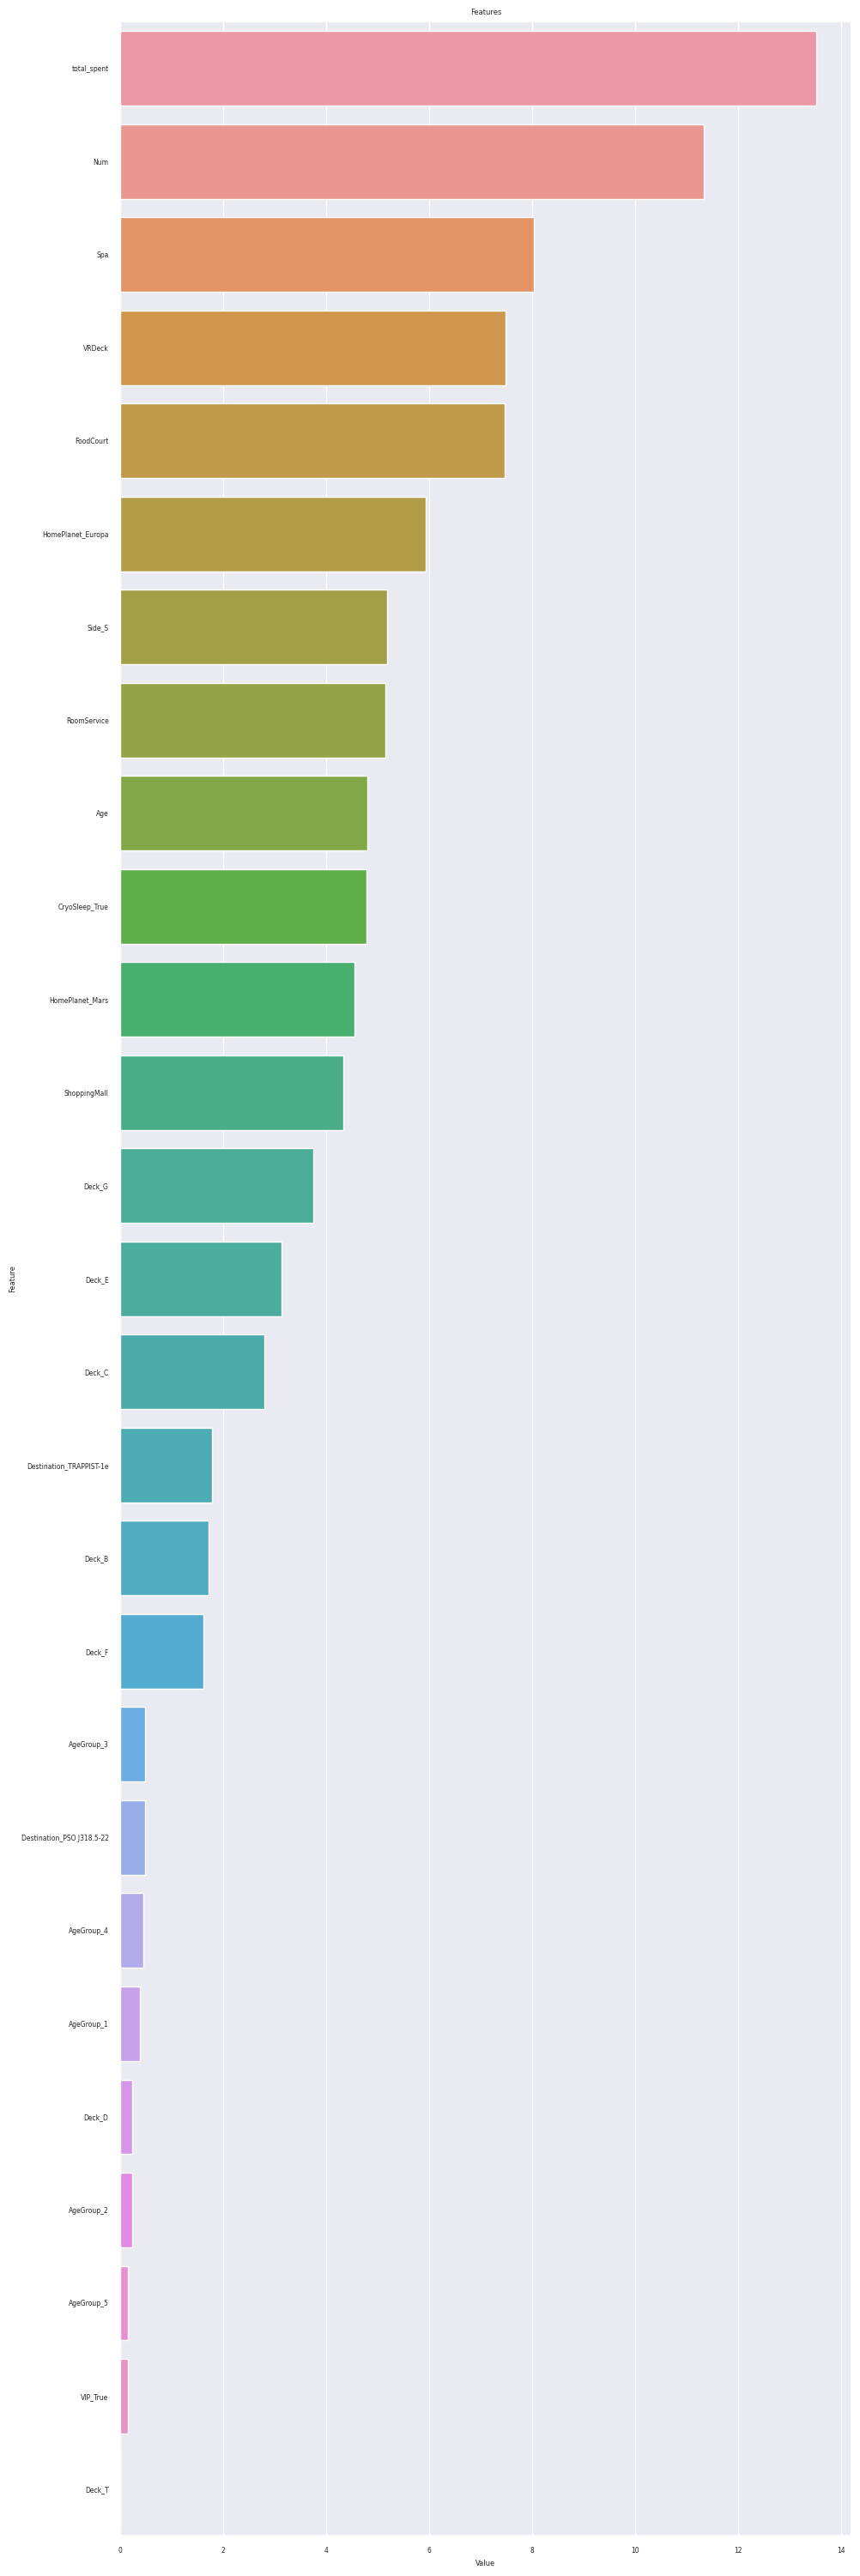

In [74]:
model = CatBoostClassifier(verbose=0)
model.fit(X, y)

plot_importance(model, X)

# Final with the Best ML Model

In [75]:
model = CatBoostClassifier(**catboost_gs_best.best_params_, verbose=False)
model.fit(X_train, y_train)
predictions = model.predict(test.drop(["PassengerId","Transported"], axis=1))

In [76]:
model.score(X_train, y_train)

0.8767615760713259

In [77]:
predictions.shape

(4277,)

In [78]:
predictions = np.expm1(predictions)
y_test = np.expm1(y_test)

In [79]:
predictions = [True if p >= 0.5 else False for p in predictions]

In [80]:
predictions[:10]

[True, False, True, True, False, False, True, True, True, True]

In [81]:
sub=pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")
sub.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [82]:
sub["Transported"] = predictions
sub.head(20)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
5,0027_01,False
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True


In [83]:
sub =sub.set_index("PassengerId")
sub

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,False
...,...
9266_02,True
9269_01,False
9271_01,True


In [84]:
sub.to_csv("titanic_space_catboost.csv")

# ANN Model

In [85]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

2024-03-06 21:27:57.179506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 21:27:57.179630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 21:27:57.305939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [86]:
#X_train.shape[1]

In [87]:
model = tf.keras.Sequential()
input_layer = tf.keras.layers.Dense(21, input_shape=(X_train.shape[1],), activation="relu")
model.add(input_layer)

model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(2048, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dropout(0.8))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=18,
    restore_best_weights=True)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8)              │            3

 Total params: 3,513,789 (13.40 MB)

 Trainable params: 3,505,709 (13.37 MB)

 Non-trainable params: 8,080 (31.56 KB)

In [88]:
history = model.fit(X_train, y_train,
                    callbacks=[early_stopping],
                    epochs=100, verbose=1, batch_size=100, validation_split=0.2)

Epoch 1/100
25/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5182 - loss: 0.8880

I0000 00:00:1709760508.698732     658 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709760508.722350     658 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.5424 - loss: 0.8473

W0000 00:00:1709760523.033789     659 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709760523.829221     658 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 290ms/step - accuracy: 0.5430 - loss: 0.8461 - val_accuracy: 0.7376 - val_loss: 0.5804
Epoch 2/100
12/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6060 - loss: 0.7546 

W0000 00:00:1709760524.595588     658 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6290 - loss: 0.7040 - val_accuracy: 0.7815 - val_loss: 0.5319
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6750 - loss: 0.6377 - val_accuracy: 0.7915 - val_loss: 0.5126
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7129 - loss: 0.5837 - val_accuracy: 0.7908 - val_loss: 0.5042
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7104 - loss: 0.5923 - val_accuracy: 0.7987 - val_loss: 0.4845
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7228 - loss: 0.5683 - val_accuracy: 0.7973 - val_loss: 0.4967
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7372 - loss: 0.5664 - val_accuracy: 0.7980 - val_loss: 0.4839
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7356 - loss: 0.5479 - val_accuracy: 0.7965 - val_loss: 0.4772
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7464 - loss: 0.5556 - val_accuracy: 0.8023 - val_loss: 0.4

In [89]:
loss_and_metrics = model.evaluate(X_test, y_test)
print(loss_and_metrics)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3324 - loss: -1.1307   

W0000 00:00:1709760537.542565     659 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3397 - loss: -1.1423
[-1.2087191343307495, 0.3456009328365326]
Loss =  -1.2087191343307495
Accuracy =  0.3456009328365326


W0000 00:00:1709760538.239426     659 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


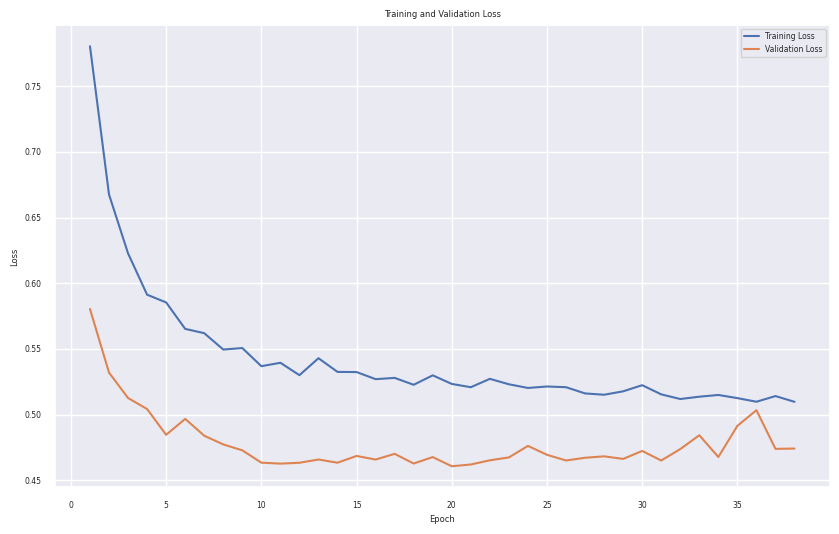

In [90]:
plt.figure(figsize=(10, 6))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [91]:
predicted = model.predict(X_test)
predicted = tf.squeeze(predicted)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

W0000 00:00:1709760539.549817     656 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


W0000 00:00:1709760540.137409     656 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [92]:
predicted

array([0, 1, 1, ..., 0, 1, 0])

# Final with the ANN Model 

In [93]:
test.head()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,total_spent,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S,CryoSleep_True,VIP_True,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,AgeGroup_5,Transported
8693,0013_01,27.000,0.000,0.000,0.000,0.000,0.000,3,0.000,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,NaN
8694,0018_01,19.000,0.000,9.000,0.000,1833.750,0.000,4,1842.750,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,NaN
8695,0019_01,31.000,0.000,0.000,0.000,0.000,0.000,0,0.000,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,NaN
8696,0021_01,38.000,0.000,2532.500,0.000,181.000,585.000,1,3298.500,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,NaN
8697,0023_01,20.000,10.000,0.000,635.000,0.000,0.000,5,645.000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,NaN


In [94]:
predicted = model.predict(test.drop(["PassengerId","Transported"], axis=1))
predicted = tf.squeeze(predicted)
predicted = np.array([True if p >= 0.5 else False for p in predicted])
actual = np.array(y_test)
predicted[:10]

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


W0000 00:00:1709760542.562380     656 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True])

In [95]:
sub = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")

In [96]:
sub["Transported"] = predicted
sub.head(20)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
5,0027_01,True
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True


In [97]:
sub =sub.set_index("PassengerId")
sub

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True
...,...
9266_02,True
9269_01,True
9271_01,True


In [98]:
sub.to_csv("titanic_space_ann.csv")

# CNN Model

In [99]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping


In [100]:
input_shape = (27, 1)  
num_classes = 1  

In [101]:
model = Sequential([
    Conv1D(128, kernel_size=1, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Conv1D(256, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Conv1D(512, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Conv1D(1024, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid') 
])


In [102]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 27, 128)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 13, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 13, 256)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 6, 512)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 3, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 1024)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 1024)        │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,272,769 (8.67 MB)

 Trainable params: 2,268,929 (8.66 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [103]:
print(X_train.shape)


(6954, 27)


In [104]:
history = model.fit(X_train, y_train,
                    callbacks=[early_stopping],
                    epochs=200, verbose=1, batch_size=200, validation_split=0.2)

Epoch 1/200
21/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6551 - loss: 0.8544

W0000 00:00:1709760558.322965     656 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6612 - loss: 0.8262

W0000 00:00:1709760566.111696     659 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709760566.906800     656 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - accuracy: 0.6618 - loss: 0.8231 - val_accuracy: 0.5981 - val_loss: 0.9107
Epoch 2/200
22/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7059 - loss: 0.6353

W0000 00:00:1709760567.862148     658 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7050 - loss: 0.6332 - val_accuracy: 0.6765 - val_loss: 0.6397
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7242 - loss: 0.5710 - val_accuracy: 0.6837 - val_loss: 0.6294
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7311 - loss: 0.5519 - val_accuracy: 0.6118 - val_loss: 0.6363
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7375 - loss: 0.5513 - val_accuracy: 0.5643 - val_loss: 0.6573
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7457 - loss: 0.5245 - val_accuracy: 0.4996 - val_loss: 0.6939
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7408 - loss: 0.5444 - val_accuracy: 0.4996 - val_loss: 0.6754
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7400 - loss: 0.5417 - val_accuracy: 0.4996 - val_loss: 0.7101
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7548 - loss: 0.5285 - val_accuracy: 0.4996 - val_loss: 0.8

In [105]:
loss_and_metrics = model.evaluate(X_test, y_test)
print(loss_and_metrics)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3602 - loss: 0.4462

W0000 00:00:1709760572.688600     658 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3630 - loss: 0.4686
[0.4828410744667053, 0.36457735300064087]
Loss =  0.4828410744667053
Accuracy =  0.36457735300064087


In [106]:
predicted = model.predict(X_test)
predicted = tf.squeeze(predicted)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

W0000 00:00:1709760574.203482     657 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [107]:
predicted

array([0, 1, 0, ..., 0, 0, 0])

In [108]:
predicted = model.predict(test.drop(["PassengerId","Transported"], axis=1))
predicted = tf.squeeze(predicted)
predicted = np.array([True if p >= 0.5 else False for p in predicted])
actual = np.array(y_test)
predicted[:10]

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


W0000 00:00:1709760577.118831     656 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([ True, False,  True, False,  True, False,  True,  True,  True,
        True])

In [109]:
sub = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")
sub

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [110]:
sub["Transported"] = predicted
sub.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,True


In [111]:
sub =sub.set_index("PassengerId")
sub.head(15)

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,False
0023_01,True
0027_01,False
0029_01,True
0032_01,True
0032_02,True


In [112]:
sub.to_csv("titanic_space_cnn.csv")